<a href="https://colab.research.google.com/github/jackp2733/cs417-labs/blob/main/Queue_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab: Grocery Checkout Queue Simulation
## Single Line vs. Multi-Queue — Which Is Better?



---

### Scenario

You're a data analyst consulting for a grocery chain. Management wants to know whether they should switch from the traditional model (each checkout lane has its own line) to a **single line** (one shared line that feeds all registers — like you see at banks or airport security).

Your job: **simulate both approaches and compare them with data.**

### Learning Objectives

By the end of this lab you will be able to:

1. Implement queue data structures using Python's `collections.deque`
2. Build a discrete-time simulation of a real-world queueing system
3. Compare two queue strategies using performance metrics (average wait, max wait, fairness)
4. Draw conclusions from simulation output

---
## Part 1: Setup & Customer Generation

Run the cell below to set up the simulation infrastructure. Read through the code and comments to understand the data model before moving on.

In [1]:
import random
from collections import deque
from dataclasses import dataclass
from copy import deepcopy

@dataclass
class Customer:
    """Represents a single grocery customer."""
    id: int
    arrival_time: int        # time step when customer arrives
    service_time: int        # how many time steps it takes to check out
    start_service_time: int = -1   # when they actually begin checkout
    finish_time: int = -1          # when they finish checkout

    @property
    def wait_time(self):
        """Time spent waiting in line (not including service)."""
        if self.start_service_time == -1:
            return None
        return self.start_service_time - self.arrival_time

    @property
    def total_time(self):
        """Total time from arrival to leaving the store."""
        if self.finish_time == -1:
            return None
        return self.finish_time - self.arrival_time


def generate_customers(n, seed=42):
    """
    Generate n customers with random arrival times and service times.

    - Customers arrive every 1-3 time steps (simulates a busy period)
    - Service time ranges from 1-12 steps (express item to full cart)
    - Wide service time range is important: it creates situations where
      one lane gets unlucky with slow shoppers.
    """
    random.seed(seed)
    customers = []
    current_time = 0

    for i in range(n):
        current_time += random.randint(1, 3)   # inter-arrival time
        service_time = random.randint(1, 12)    # checkout duration
        customers.append(Customer(id=i, arrival_time=current_time, service_time=service_time))

    return customers


# Generate our test group
NUM_CUSTOMERS = 30
NUM_REGISTERS = 3

# We use deepcopy so each simulation gets its own Customer objects
customers_template = generate_customers(NUM_CUSTOMERS, seed=42)

print(f"Generated {NUM_CUSTOMERS} customers for {NUM_REGISTERS} registers.")
print(f"\nFirst 5 customers:")
for c in customers_template[:5]:
    print(f"  Customer {c.id}: arrives at t={c.arrival_time}, needs {c.service_time} time steps to check out")
print(f"\nService time range: "
      f"{min(c.service_time for c in customers_template)} – {max(c.service_time for c in customers_template)} steps")

Generated 30 customers for 3 registers.

First 5 customers:
  Customer 0: arrives at t=3, needs 2 time steps to check out
  Customer 1: arrives at t=4, needs 12 time steps to check out
  Customer 2: arrives at t=6, needs 4 time steps to check out
  Customer 3: arrives at t=7, needs 3 time steps to check out
  Customer 4: arrives at t=10, needs 2 time steps to check out

Service time range: 1 – 12 steps


### Quick Check

Before moving on, make sure you understand:
- Each customer has an `arrival_time` (when they show up) and a `service_time` (how long checkout takes)
- `wait_time` = how long they stand in line *before* getting to a register
- We use the **same** customer data for both simulations so the comparison is fair
- Service times vary widely (1–12) — some shoppers have a few items, others a full cart

---
## Part 2: Multi-Queue Simulation

In the **multi-queue** model, each register has its own line. Customers are assigned to lanes in **round-robin** order as they arrive: Customer 0 → Lane 0, Customer 1 → Lane 1, Customer 2 → Lane 2, Customer 3 → Lane 0, and so on. Once assigned, a customer is **stuck in that lane** — no switching.

Each lane works like a queue: customers are served in FIFO order by that lane's single cashier. A customer can't start checkout until everyone ahead of them in their lane is done.

**Your task:** Complete the simulation by filling in the `# TODO` sections.

In [5]:
def simulate_multi_queue(customers, num_registers):
    """
    Simulate the multi-queue model.
    Customers are assigned to lanes round-robin.
    Each lane has its own deque and one cashier.
    """
    # Create a deque for each lane
    lanes = [deque() for _ in range(num_registers)]

    # ---- TODO 1 ----
    # Distribute customers across lanes using round-robin.
    # Customer 0 → lane 0, Customer 1 → lane 1, Customer 2 → lane 2,
    # Customer 3 → lane 0, etc.
    # Hint: use the modulo operator (%) to cycle through lanes.

    for i, customer in enumerate(customers):
        lane_idx = i % num_registers # <-- REPLACE THIS LINE (which lane does customer i go to?)
        lanes[lane_idx].append(customer)

    # ---- TODO 2 ----
    # Process each lane independently.
    # For each lane, go through customers in FIFO order:
    #   - A customer starts when the previous customer finishes
    #     OR when they arrive, whichever is LATER.
    #   - finish_time = start_service_time + service_time
    #
    # We use prev_finish to track when the cashier becomes free.

    for lane in lanes:
        prev_finish = 0  # tracks when the cashier becomes free
        for customer in lane:
            customer.start_service_time = max(prev_finish, customer.arrival_time)
            customer.finish_time = customer.start_service_time + customer.service_time         # <-- REPLACE THIS LINE
            prev_finish = customer.start_service_time + customer.service_time

    return customers


# Run the simulation
customers_multi = deepcopy(customers_template)
results_multi = simulate_multi_queue(customers_multi, NUM_REGISTERS)

# Quick sanity check
print("Multi-Queue Results (first 9 customers):")
for c in results_multi[:9]:
    lane = c.id % NUM_REGISTERS
    print(f"  Customer {c.id} (Lane {lane}): arrived t={c.arrival_time}, "
          f"served at t={c.start_service_time}, done t={c.finish_time}, "
          f"waited {c.wait_time} steps")

Multi-Queue Results (first 9 customers):
  Customer 0 (Lane 0): arrived t=3, served at t=3, done t=5, waited 0 steps
  Customer 1 (Lane 1): arrived t=4, served at t=4, done t=16, waited 0 steps
  Customer 2 (Lane 2): arrived t=6, served at t=6, done t=10, waited 0 steps
  Customer 3 (Lane 0): arrived t=7, served at t=7, done t=10, waited 0 steps
  Customer 4 (Lane 1): arrived t=10, served at t=16, done t=18, waited 6 steps
  Customer 5 (Lane 2): arrived t=13, served at t=13, done t=25, waited 0 steps
  Customer 6 (Lane 0): arrived t=16, served at t=16, done t=18, waited 0 steps
  Customer 7 (Lane 1): arrived t=19, served at t=19, done t=26, waited 0 steps
  Customer 8 (Lane 2): arrived t=20, served at t=25, done t=26, waited 5 steps


<details>
<summary><b>Click here for hints if you're stuck</b></summary>

**TODO 1:**
```python
lane_idx = i % num_registers
```

**TODO 2:**
```python
customer.start_service_time = max(prev_finish, customer.arrival_time)
customer.finish_time = customer.start_service_time + customer.service_time
```
The `max()` is key: if the cashier is still busy (`prev_finish` is in the future), the customer waits. If the cashier is already free, the customer starts right when they arrive.
</details>

---
## Part 3: Single Line Simulation

In the **single line** model, there's one shared queue. Whenever a register opens up, the **next person in line** goes to that register — no one gets stuck behind a slow shopper while another register sits idle.

**Your task:** Complete the simulation below.

In [3]:
def simulate_single_line(customers, num_registers):
    """
    Simulate the single line model.
    One shared queue, multiple registers.
    Each customer goes to whichever register opens first.
    """
    # Track when each register becomes free
    register_free_at = [0] * num_registers

    for customer in customers:
        t = customer.arrival_time

        # ---- TODO 3 ----
        # Find the register that will be free the EARLIEST.
        # Hint: use min() with range(num_registers) and a key function
        # that looks up register_free_at.

        best_register = min(range(num_registers), key=lambda i: register_free_at[i] )  # <-- REPLACE THIS LINE

        # ---- TODO 4 ----
        # The customer starts when the register is free OR when
        # they arrive, whichever is later. Then compute finish time.

        customer.start_service_time = max(register_free_at[best_register], t)  # <-- REPLACE THIS LINE
        customer.finish_time = customer.start_service_time + customer.service_time         # <-- REPLACE THIS LINE

        # Update that register's availability
        register_free_at[best_register] = customer.finish_time

    return customers


# Run the simulation
customers_single = deepcopy(customers_template)
results_single = simulate_single_line(customers_single, NUM_REGISTERS)

# Quick sanity check
print("Single Line Results (first 9 customers):")
for c in results_single[:9]:
    print(f"  Customer {c.id}: arrived t={c.arrival_time}, "
          f"served at t={c.start_service_time}, done t={c.finish_time}, "
          f"waited {c.wait_time} steps")

Single Line Results (first 9 customers):
  Customer 0: arrived t=3, served at t=3, done t=5, waited 0 steps
  Customer 1: arrived t=4, served at t=4, done t=16, waited 0 steps
  Customer 2: arrived t=6, served at t=6, done t=10, waited 0 steps
  Customer 3: arrived t=7, served at t=7, done t=10, waited 0 steps
  Customer 4: arrived t=10, served at t=10, done t=12, waited 0 steps
  Customer 5: arrived t=13, served at t=13, done t=25, waited 0 steps
  Customer 6: arrived t=16, served at t=16, done t=18, waited 0 steps
  Customer 7: arrived t=19, served at t=19, done t=26, waited 0 steps
  Customer 8: arrived t=20, served at t=20, done t=21, waited 0 steps


<details>
<summary><b>Click here for hints if you're stuck</b></summary>

**TODO 3:**
```python
best_register = min(range(num_registers), key=lambda i: register_free_at[i])
```

**TODO 4:**
```python
customer.start_service_time = max(register_free_at[best_register], t)
customer.finish_time = customer.start_service_time + customer.service_time
```

Notice the per-customer logic is the same `max()`/addition pattern as Part 2 — the difference is *structural*. In the single line, every customer is guaranteed to go to the next available register. In multi-queue, you're stuck in your assigned lane regardless.
</details>

---
## Part 4: Compare and Analyze

Now let's put the two models head-to-head. Run the analysis cells below, then answer the discussion questions.

In [6]:
import statistics

def compute_metrics(results):
    """Compute key performance metrics."""
    wait_times = [c.wait_time for c in results]
    total_times = [c.total_time for c in results]

    metrics = {
        "Avg Wait Time": f"{statistics.mean(wait_times):.1f}",
        "Max Wait Time": f"{max(wait_times)}",
        "Std Dev (Wait)": f"{statistics.stdev(wait_times):.1f}",
        "Avg Total Time": f"{statistics.mean(total_times):.1f}",
        "Max Total Time": f"{max(total_times)}",
        "Customers w/ Zero Wait": f"{sum(1 for w in wait_times if w == 0)}/{len(wait_times)}",
    }
    return metrics


metrics_multi = compute_metrics(results_multi)
metrics_single = compute_metrics(results_single)

# Display comparison table
print(f"{'Metric':<28} {'Multi-Queue':>12} {'Single Line':>12}")
print("-" * 54)
for key in metrics_multi:
    print(f"{key:<28} {metrics_multi[key]:>12} {metrics_single[key]:>12}")

Metric                        Multi-Queue  Single Line
------------------------------------------------------
Avg Wait Time                         3.7          1.7
Max Wait Time                          15            9
Std Dev (Wait)                        4.6          2.2
Avg Total Time                        9.6          7.6
Max Total Time                         19           18
Customers w/ Zero Wait              15/30        16/30


/tmp/ipython-input-1067399796.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot([waits_multi, waits_single],


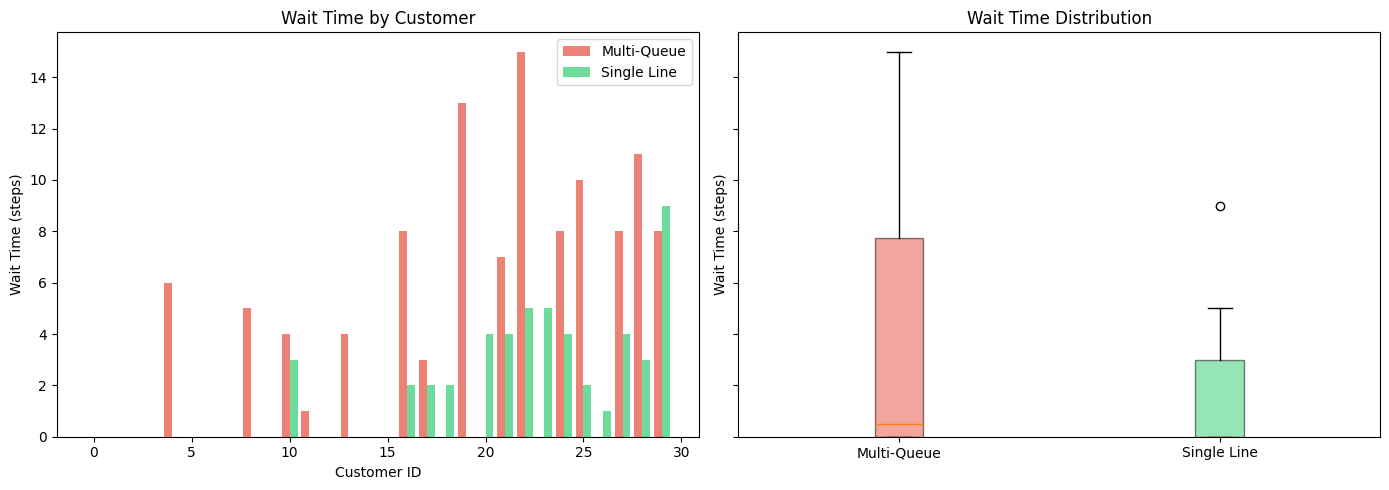

In [7]:
# Visualization: Wait time per customer for both models
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Wait times comparison - grouped bar chart
ids = [c.id for c in results_multi]
waits_multi = [c.wait_time for c in results_multi]
waits_single = [c.wait_time for c in results_single]

bar_width = 0.4
axes[0].bar([x - bar_width/2 for x in ids], waits_multi, bar_width,
            color='#e74c3c', alpha=0.7, label='Multi-Queue')
axes[0].bar([x + bar_width/2 for x in ids], waits_single, bar_width,
            color='#2ecc71', alpha=0.7, label='Single Line')
axes[0].set_xlabel('Customer ID')
axes[0].set_ylabel('Wait Time (steps)')
axes[0].set_title('Wait Time by Customer')
axes[0].legend()

# Distribution comparison - box plot
bp = axes[1].boxplot([waits_multi, waits_single],
                     labels=['Multi-Queue', 'Single Line'],
                     patch_artist=True)
bp['boxes'][0].set_facecolor('#e74c3c')
bp['boxes'][0].set_alpha(0.5)
bp['boxes'][1].set_facecolor('#2ecc71')
bp['boxes'][1].set_alpha(0.5)
axes[1].set_ylabel('Wait Time (steps)')
axes[1].set_title('Wait Time Distribution')

plt.tight_layout()
plt.show()

---
## Discussion Questions

Answer these in a text cell below or discuss with your neighbor:

1. **Which model had a lower average wait time?** Was the difference large or small?

2. **Which model was more *fair*?** (Hint: look at the standard deviation and max wait time. A fairer system means less variation — nobody gets stuck with a terrible wait while others breeze through.)

3. **Why does the single line tend to perform better?** Think about what happens in the multi-queue model when your lane happens to get several slow shoppers in a row.

4. **Where have you seen each model in real life?** Why don't all stores use the single line model if it's better?

*Your answers here:*

1. The single lne model had an average wait time of 1.7 while the multi line model had a longer average wait time of 3.7 which is over twice as long.

2. I think the single lne model was more fair because there was less variation with the wait times.

3. The single lne model performs better because if you get stuck behind a couple slow shoppers in the multi lne model you are stuck there unable to switch lines.

4. At Lowe's there is a single line for the selfcheckout registers since there is four of them. At grocery stores such as Shaws usually it's multi line cashiers. I think most places don't adopt this because very rarely are there more than 2 or 3 people behind the registers at once and not 30 customers at a time checking out.

---
## Bonus Challenges (if you finish early)

Try one or more of these extensions:

- **Smarter line picking:** Instead of round-robin, what if customers in the multi-queue model always join the **shortest line**? Does that close the gap with the single line? (Hint: you'll need to track queue length or estimated wait per lane as customers arrive.)
- **Change the parameters:** What happens with 5 registers? 60 customers? A faster arrival rate (`randint(1, 2)`)?
- **Add an express lane:** In the multi-queue model, reserve one register for customers with `service_time <= 3`. Does this help?
- **Track queue length over time:** At each time step, record how many people are waiting. Plot queue length over time for both models.

In [ ]:
# Bonus work here
